### Spearman Rank Correlation for CNA Scores Across Pairs of Methods and Modalities

Get average CNA score per chromosome arm for all analyses: <br>
Infercnv on Slide-seq data <br>
Infercnv on single-nucleus data <br>
SlideCNA on Slide-seq data <br>
SlideCNA on single-nucleus data <br>
CopyKAT on Slide-seq data <br>
CopyKAT on single-nucleus data <br>
ABSOLUTE on WES data (HTAPP-895-SMP-7359 only) <br>

Download data of samples from https://zenodo.org/records/13750860 <br>
<br>
HTAPP-878-SMP-7149_correlation.tar.gz <br>
HTAPP-880-SMP-7179_correlation.tar.gz <br>
HTAPP-895-SMP-7359_correlation.tar.gz <br>
HTAPP-944-SMP-7479_correlation.tar.gz <br>

In [1]:
# Set paths to data and results
path_to_data <- "path/to/data/" 
path_to_results <- "path/to/results/"

In [3]:
libraries <- c("ggplot2", "Seurat", "glue", "dplyr", "anndata", "spacexr", 
               "data.table", "Matrix", "mltools", "enrichR", "R.utils")
lapply(libraries, function(x) suppressMessages(require(x, character.only = TRUE,quietly=TRUE,warn.conflicts = FALSE)))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [4]:
setwd('/ahg/regevdata/users/dzhang/projects/HTAPP_MBC/src/slide_CNV_official/SlideCNA_Analysis/')

In [5]:
# Assumes you're working in the repository root directory
source("code/correlation.R")
source("code/utils.R")


Attaching package: 'tidyr'


The following object is masked from 'package:R.utils':

    extract


The following object is masked from 'package:mltools':

    replace_na


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


corrplot 0.94 loaded

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following object is masked from 'package:SeuratObject':

    intersect


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank,

In [6]:
### Annotate GENCODE genes for Ensembl ID
gene_pos_complete <- fread(glue("data/gencode_v19_gen_pos.complete.txt"))
setnames(gene_pos_complete,
         names(gene_pos_complete),
         c("GENE","chr","start","end"))
gene_pos_complete <- gene_pos_complete %>%
    separate_wider_delim(GENE, "|", names=c("GENE", "ENSEMBL_ID")) %>%
    mutate(ENSEMBL_ID=sub("\\.\\d+$", "", ENSEMBL_ID))

In [8]:
head(gene_pos_complete)

GENE,ENSEMBL_ID,chr,start,end
<chr>,<chr>,<chr>,<int>,<int>
TMEM200B,ENSG00000253304,chr1,29445940,29450447
TMEM82,ENSG00000162460,chr1,16068917,16074477
NIT1,ENSG00000158793,chr1,161087876,161095235
AL356356.1,ENSG00000225996,chr1,150521897,150524367
RP11-109P14.10,ENSG00000230955,chr1,38326369,38327252
RP11-157N3.1,ENSG00000231671,chr1,101788893,101855859


#### HTAPP-878-SMP-7149

In [9]:
sample <- "HTAPP-878-SMP-7149"

In [10]:
infercnv_obj_slide = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_slide'))
infercnv_slide <- infercnv_bands(infercnv_obj_slide, gene_pos_complete, "infercnv_slide") 

[1] "N genes: 452"
[1] "N genes with karyotype band annotations: 449"


In [11]:
infercnv_obj_sc = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_sc'))
infercnv_sc <- infercnv_bands(infercnv_obj_sc, gene_pos_complete, "infercnv_sc", malig_filt=FALSE) 

[1] "N genes: 7122"
[1] "N genes with karyotype band annotations: 7037"


In [12]:
load(glue('{path_to_data}/{sample}/cnv_data2_slide.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_slide.Robj'))
slidecna_slide <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_slide")

[1] "N genes: 8951"
[1] "N genes with karyotype band annotations: 8838"


In [13]:
load(glue('{path_to_data}/{sample}/cnv_data2_sc.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_sc.Robj'))
slidecna_sc <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_sc")

[1] "N genes: 14481"
[1] "N genes with karyotype band annotations: 14056"


In [14]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_slide.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_slide.Robj"))
copykat_slide <- copykat_bands(ck_results, md, sample, "copykat_slide")

In [15]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_sc.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_sc.Robj"))
copykat_sc <- copykat_bands(ck_results, md, sample, "copykat_sc")

In [16]:
analysis_list <- list(infercnv_slide, infercnv_sc, 
                      slidecna_slide, slidecna_sc,
                     copykat_slide, copykat_sc)

# merge all average cna score dataframes for each analysis type in list
# include all chromosome arms, even those with NAs in some analyses
all_cna_avgs <- Reduce(function(x, y) merge(x, y, by="arm", all=TRUE), analysis_list)
all_cna_avgs <- all_cna_avgs[(str_order(all_cna_avgs$arm, numeric = TRUE)),]
head(all_cna_avgs)
                       
# merge all average cna score dataframes for each analysis type in list
# only include chromosome arms shared across all analyses; there should be no NAs
all_cna_avgs_shared <- Reduce(function(x, y) merge(x, y, by="arm", all=FALSE), analysis_list)
all_cna_avgs_shared <- all_cna_avgs_shared[(str_order(all_cna_avgs_shared$arm, numeric = TRUE)),]

,arm,infercnv_slide,infercnv_sc,slidecna_slide,slidecna_sc,copykat_slide,copykat_sc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,1p,1.0124494,0.9943367,0.9912117,0.9455246,1.0207097,0.9477692
19,1q,1.0203434,1.0137978,1.0667501,1.0987817,1.0015540,1.0456130
24,2p,0.9910610,0.9948006,1.0006616,0.9757525,0.9977062,1.0052116
25,2q,0.9911674,0.9999730,1.0018000,0.9666091,1.0162624,0.9973487
26,3p,1.0065281,0.9909656,1.0023251,0.9124205,0.9917428,0.9900471
27,3q,1.0042955,0.9980415,0.9780950,0.9646924,1.0250573,0.9969305


In [17]:
### Make heat map of average CNAs across analyses

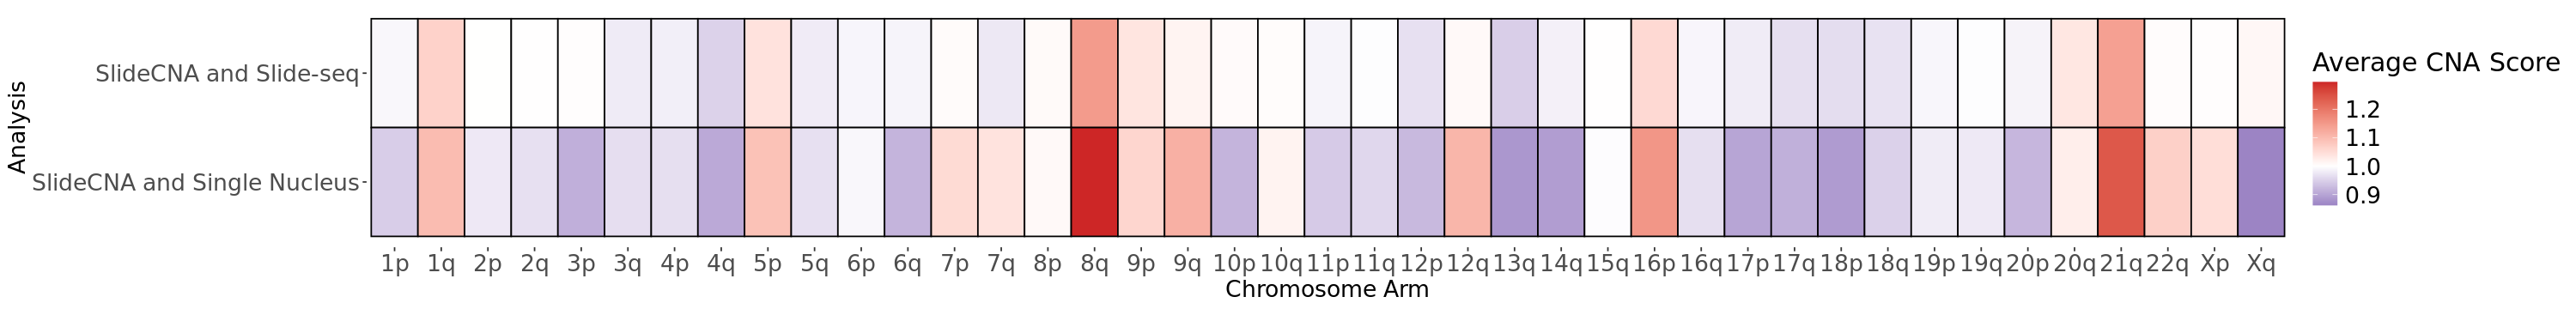

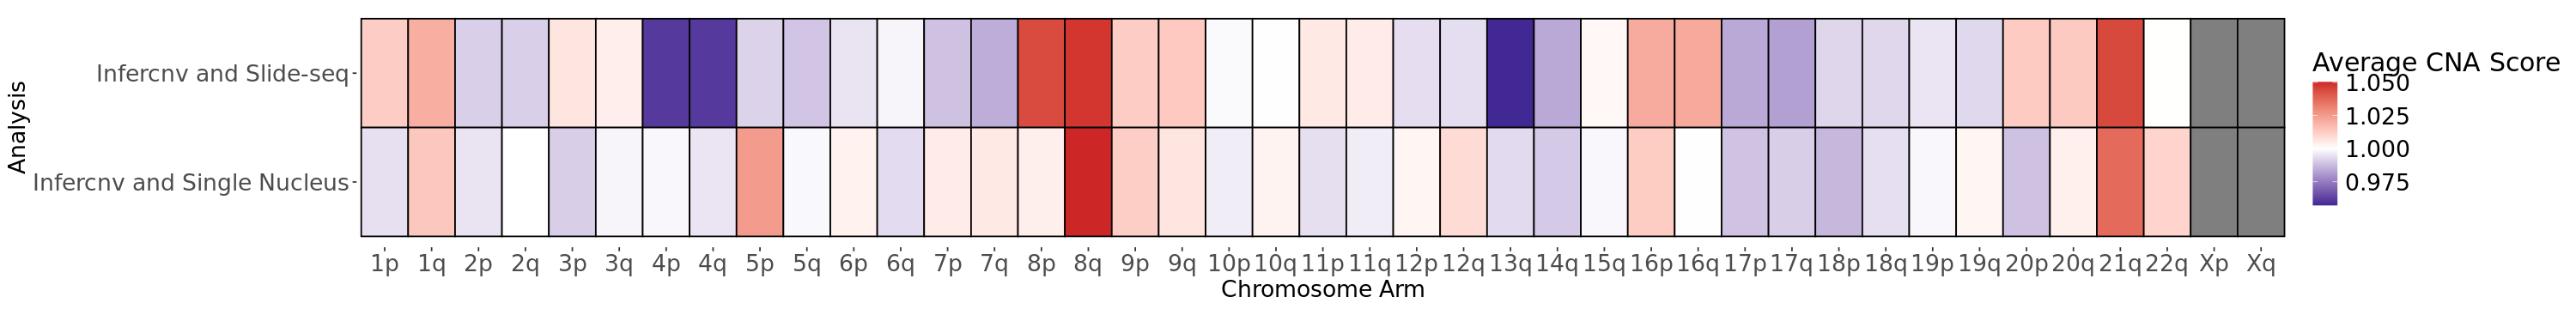

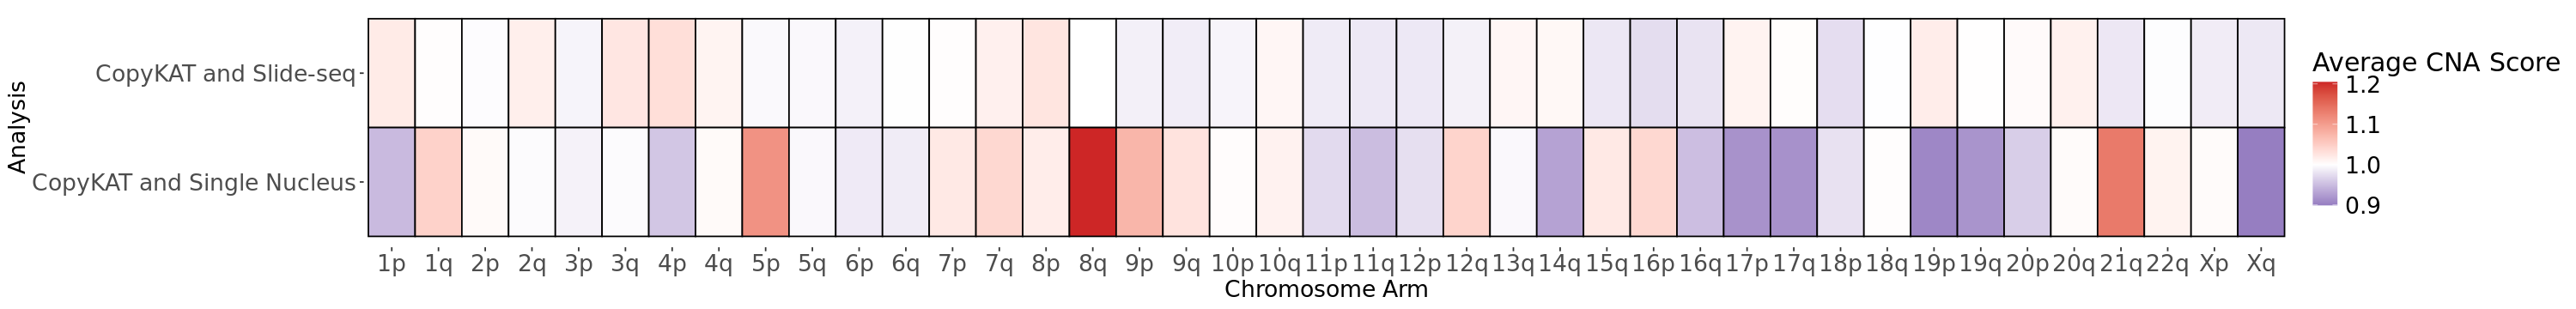

In [81]:
avg_cna_heatmap (all_cna_avgs, 'slidecna', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'infercnv', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'copykat', path_to_results)

In [73]:
### Get pairwise spearman correlation for all analyses

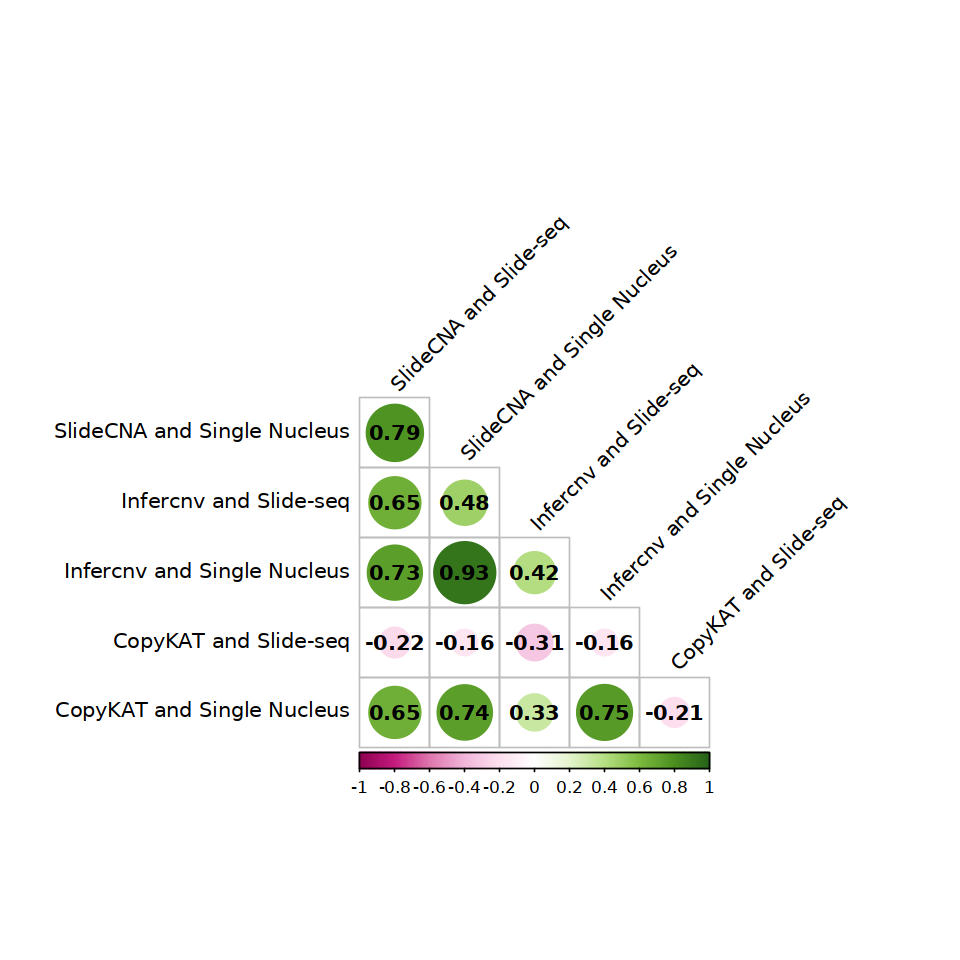

In [75]:
all_corr_plot(all_cna_avgs_shared, path_to_results)

#### HTAPP-880-SMP-7179

In [24]:
sample <- "HTAPP-880-SMP-7179"

In [25]:
infercnv_obj_slide = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_slide'))
infercnv_slide <- infercnv_bands(infercnv_obj_slide, gene_pos_complete, "infercnv_slide") 

[1] "N genes: 719"
[1] "N genes with karyotype band annotations: 715"


In [26]:
infercnv_obj_sc = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_sc'))
infercnv_sc <- infercnv_bands(infercnv_obj_sc, gene_pos_complete, "infercnv_sc", malig_filt=FALSE) 

[1] "N genes: 6065"
[1] "N genes with karyotype band annotations: 5993"


In [27]:
load(glue('{path_to_data}/{sample}/cnv_data2_slide.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_slide.Robj'))
slidecna_slide <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_slide")

[1] "N genes: 9313"
[1] "N genes with karyotype band annotations: 9164"


In [28]:
load(glue('{path_to_data}/{sample}/cnv_data2_sc.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_sc.Robj'))
slidecna_sc <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_sc")

[1] "N genes: 13677"
[1] "N genes with karyotype band annotations: 13302"


In [29]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_slide.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_slide.Robj"))
copykat_slide <- copykat_bands(ck_results, md, sample, "copykat_slide")

In [30]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_sc.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_sc.Robj"))
copykat_sc <- copykat_bands(ck_results, md, sample, "copykat_sc")

In [31]:
analysis_list <- list(infercnv_slide, infercnv_sc, 
                      slidecna_slide, slidecna_sc,
                     copykat_slide, copykat_sc)

# merge all average cna score dataframes for each analysis type in list
# include all chromosome arms, even those with NAs in some analyses
all_cna_avgs <- Reduce(function(x, y) merge(x, y, by="arm", all=TRUE), analysis_list)
all_cna_avgs <- all_cna_avgs[(str_order(all_cna_avgs$arm, numeric = TRUE)),]
head(all_cna_avgs)
                       
# merge all average cna score dataframes for each analysis type in list
# only include chromosome arms shared across all analyses; there should be no NAs
all_cna_avgs_shared <- Reduce(function(x, y) merge(x, y, by="arm", all=FALSE), analysis_list)
all_cna_avgs_shared <- all_cna_avgs_shared[(str_order(all_cna_avgs_shared$arm, numeric = TRUE)),]

,arm,infercnv_slide,infercnv_sc,slidecna_slide,slidecna_sc,copykat_slide,copykat_sc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,1p,0.9998204,0.9884086,0.9666684,0.9506650,1.0042013,1.0079398
19,1q,1.0335726,1.0399146,1.0849140,1.1130001,0.9955315,0.9915273
24,2p,0.9511911,0.9371781,0.9259805,0.8833281,1.0124350,1.0250582
25,2q,0.9525199,0.9713294,0.9333598,0.8936402,1.0117802,1.0058793
26,3p,0.9974425,1.0184723,1.0380924,1.1008918,1.0114686,0.9881268
27,3q,0.9963358,1.0043719,1.0235674,1.0290104,1.0085432,0.9871896


In [32]:
### Make heat map of average CNAs across analyses

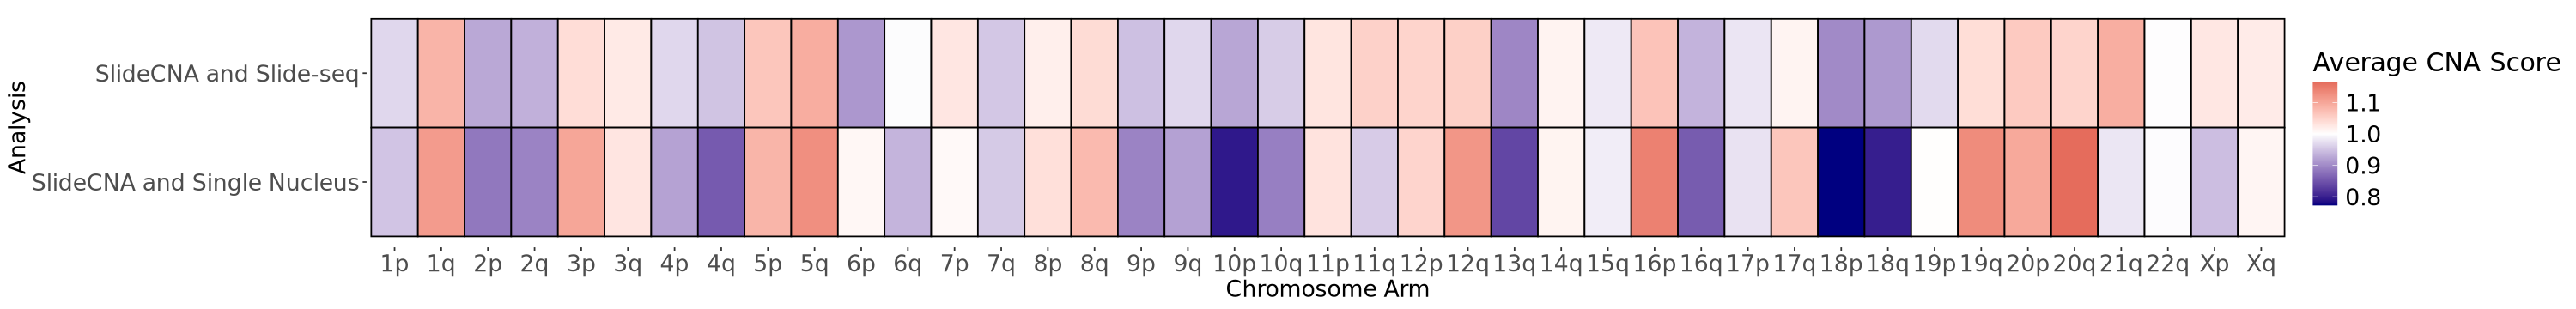

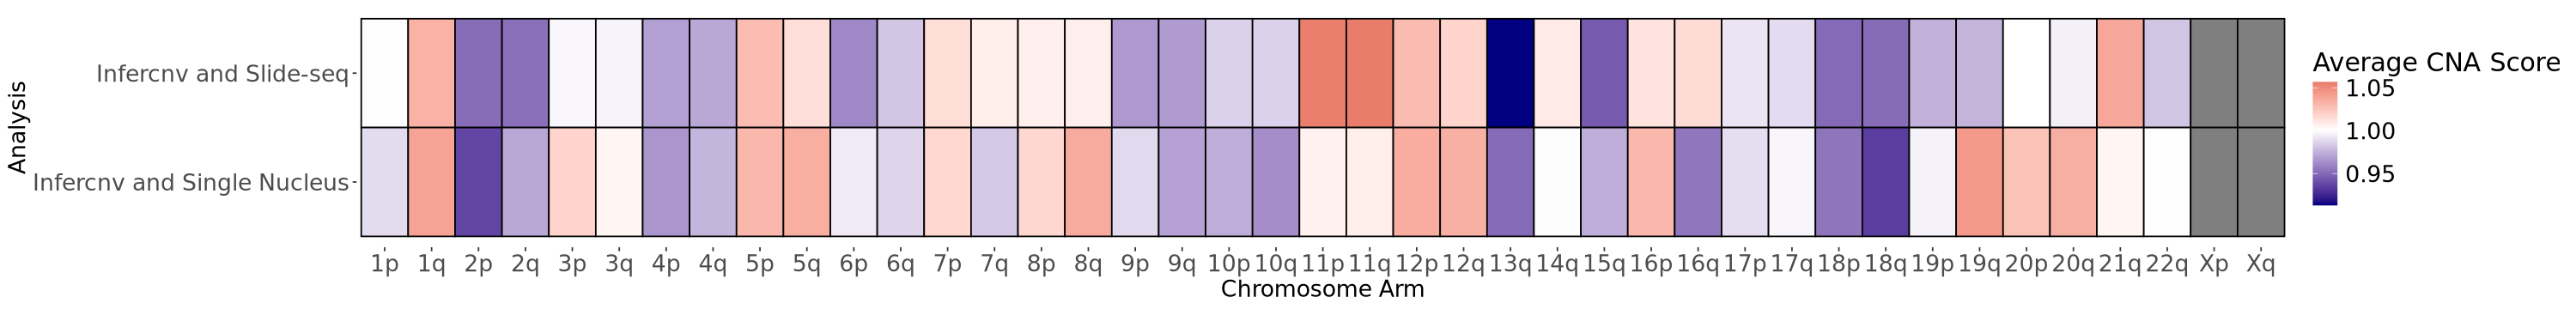

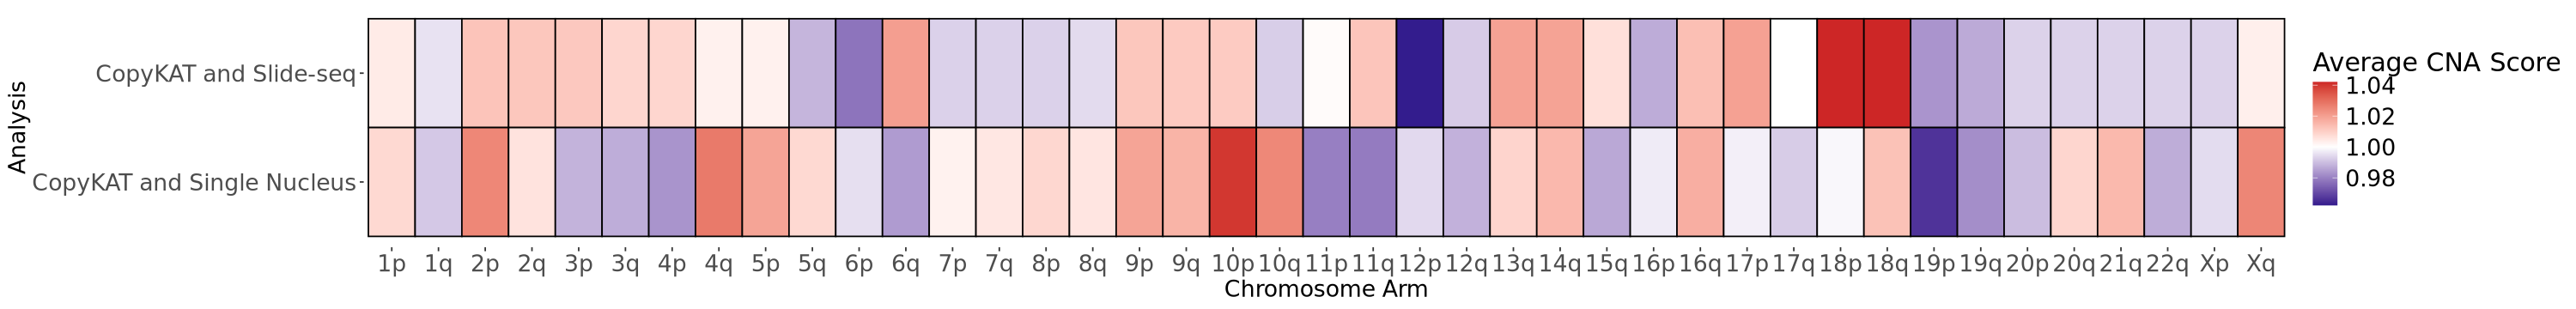

In [34]:
avg_cna_heatmap (all_cna_avgs, 'slidecna', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'infercnv', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'copykat', path_to_results)

In [35]:
### Get pairwise spearman correlation for all analyses

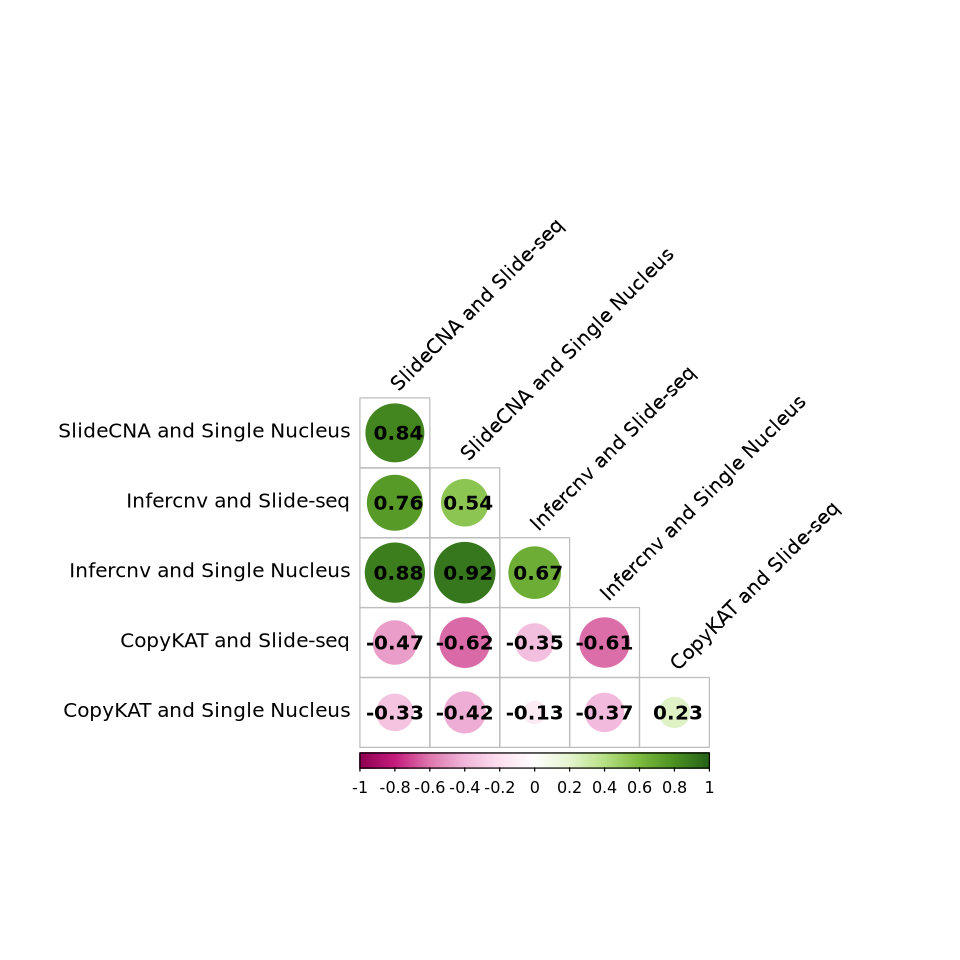

In [36]:
all_corr_plot(all_cna_avgs_shared, path_to_results)

#### HTAPP-895-SMP-7359

In [37]:
sample <- "HTAPP-895-SMP-7359"

In [38]:
infercnv_obj_slide = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_slide'))
infercnv_slide <- infercnv_bands(infercnv_obj_slide, gene_pos_complete, "infercnv_slide") 

[1] "N genes: 1490"
[1] "N genes with karyotype band annotations: 1480"


In [39]:
infercnv_obj_sc = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_sc'))
infercnv_sc <- infercnv_bands(infercnv_obj_sc, gene_pos_complete, "infercnv_sc", malig_filt=FALSE) 

[1] "N genes: 8464"
[1] "N genes with karyotype band annotations: 8354"


In [40]:
load(glue('{path_to_data}/{sample}/cnv_data2_slide.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_slide.Robj'))
slidecna_slide <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_slide")

[1] "N genes: 8718"
[1] "N genes with karyotype band annotations: 8597"


In [41]:
load(glue('{path_to_data}/{sample}/cnv_data2_sc.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_sc.Robj'))
slidecna_sc <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_sc")

[1] "N genes: 14688"
[1] "N genes with karyotype band annotations: 14217"


In [42]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_slide.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_slide.Robj"))
copykat_slide <- copykat_bands(ck_results, md, sample, "copykat_slide")

In [43]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_sc.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_sc.Robj"))
copykat_sc <- copykat_bands(ck_results, md, sample, "copykat_sc")

In [45]:
wes_data <- read.table(glue("{path_to_data}/{sample}/recapseg.BRCA-05246_CCPM_0300535-Tumor-SM-E764S.seg"), header = TRUE)

In [46]:
absolute_wes <- absolute_bands(wes_data, analysis="absolute_wes")

In [47]:
analysis_list <- list(infercnv_slide, infercnv_sc, 
                      slidecna_slide, slidecna_sc,
                     copykat_slide, copykat_sc,
                      absolute_wes)

# merge all average cna score dataframes for each analysis type in list
# include all chromosome arms, even those with NAs in some analyses
all_cna_avgs <- Reduce(function(x, y) merge(x, y, by="arm", all=TRUE), analysis_list)
all_cna_avgs <- all_cna_avgs[(str_order(all_cna_avgs$arm, numeric = TRUE)),]
head(all_cna_avgs)
                       
# merge all average cna score dataframes for each analysis type in list
# only include chromosome arms shared across all analyses; there should be no NAs
all_cna_avgs_shared <- Reduce(function(x, y) merge(x, y, by="arm", all=FALSE), analysis_list)
all_cna_avgs_shared <- all_cna_avgs_shared[(str_order(all_cna_avgs_shared$arm, numeric = TRUE)),]

,arm,infercnv_slide,infercnv_sc,slidecna_slide,slidecna_sc,copykat_slide,copykat_sc,absolute_wes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,1p,1.0011490,1.0202138,1.0244656,1.1250455,0.9892555,1.0423892,1.0068397
19,1q,1.0030223,1.0005863,1.0072474,0.9911103,1.0156846,0.9908831,1.0099105
25,2p,0.9790883,0.9826149,0.9795493,0.9800392,1.0186370,1.0016506,1.0026770
26,2q,0.9754660,0.9362781,0.9435871,0.7981255,1.0022745,0.9129608,0.9884851
27,3p,0.9957596,1.0077110,0.9983192,1.0601738,1.0000826,1.0395607,1.1448295
28,3q,0.9995073,0.9949643,0.9970947,1.0425384,1.0115744,1.0385247,1.0213808


In [48]:
### Make heat map of average CNAs across analyses

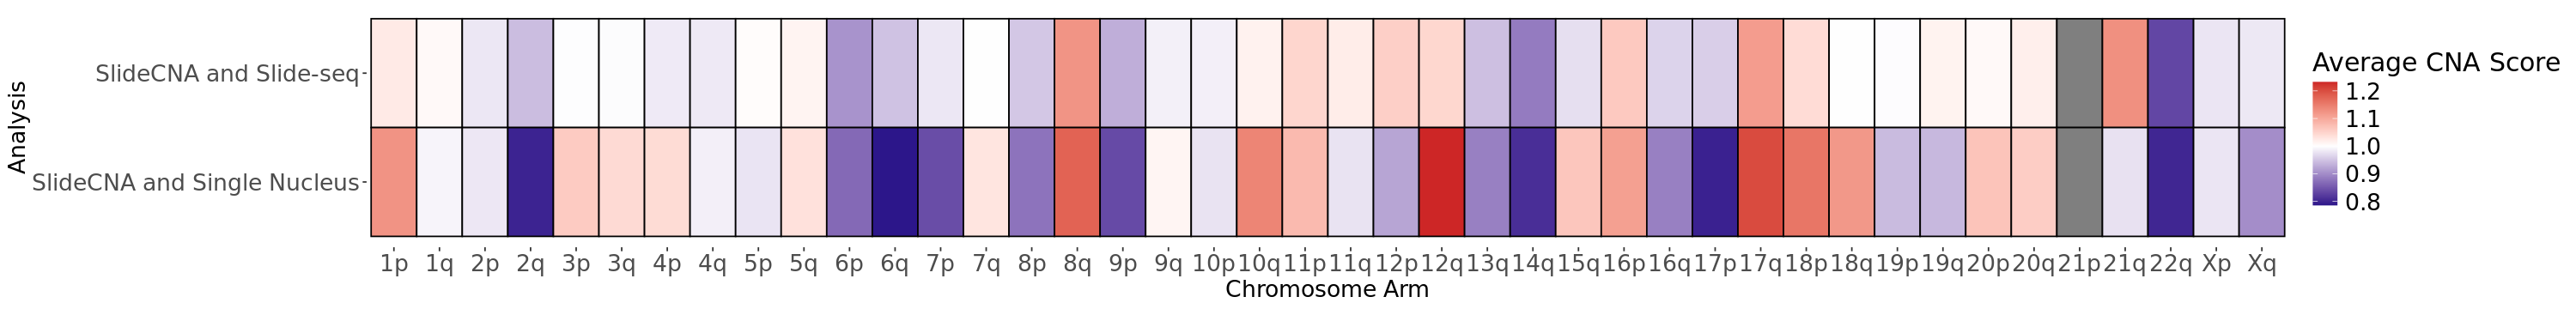

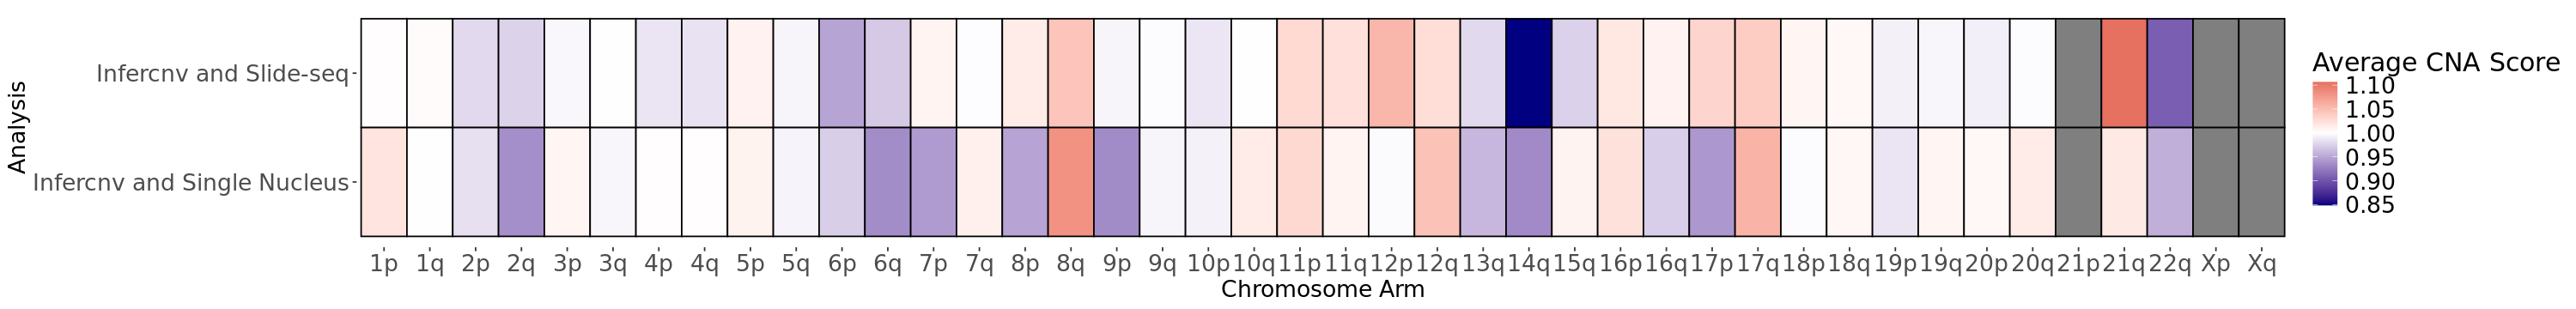

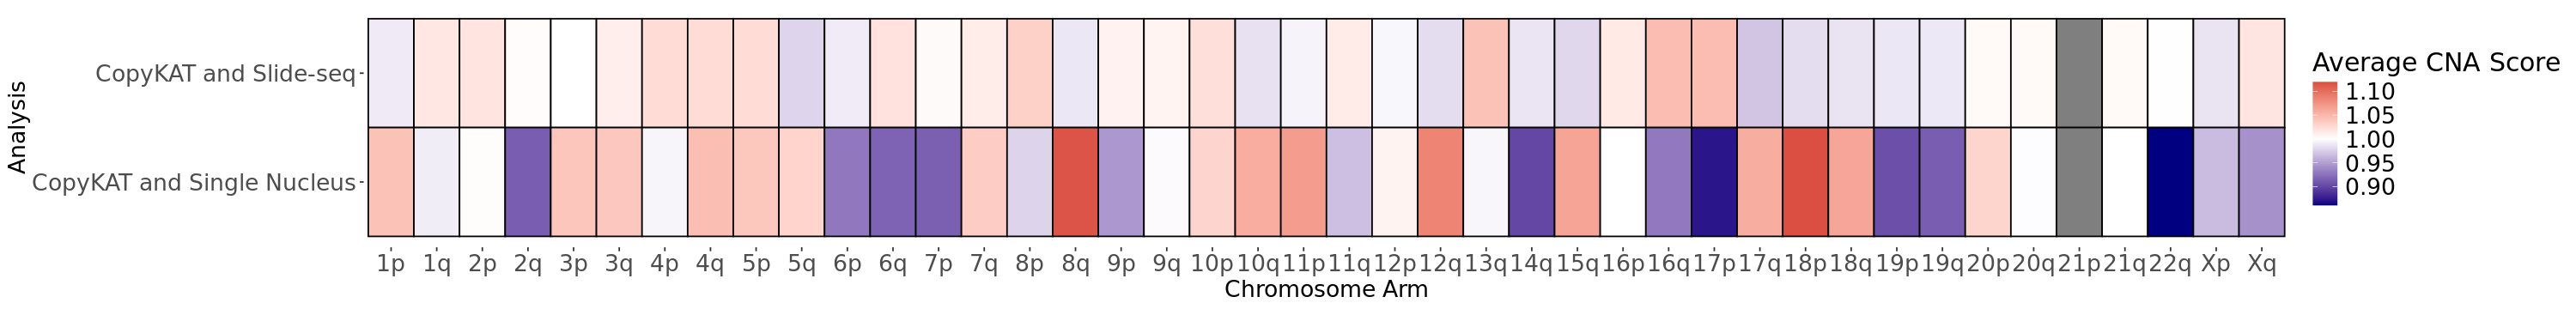

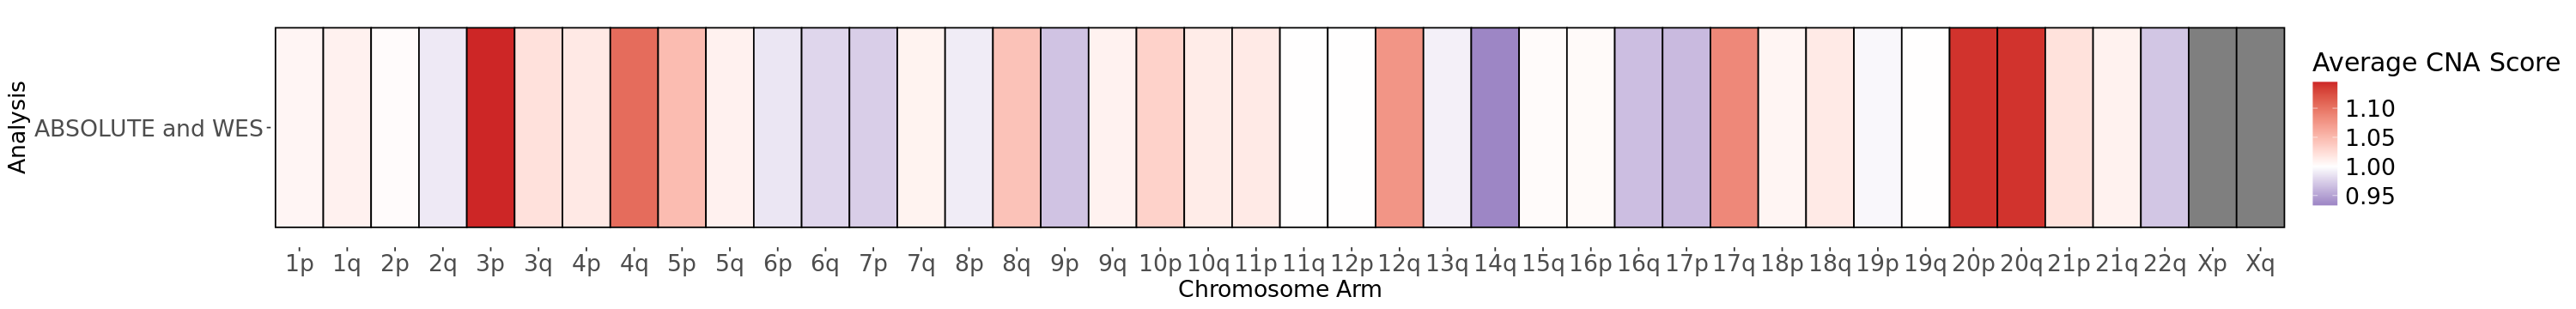

In [50]:
avg_cna_heatmap(all_cna_avgs, 'slidecna', path_to_results)
avg_cna_heatmap(all_cna_avgs, 'infercnv', path_to_results)
avg_cna_heatmap(all_cna_avgs, 'copykat', path_to_results)
avg_cna_heatmap(all_cna_avgs, 'absolute', path_to_results)

In [29]:
### Get pairwise spearman correlation for all analyses

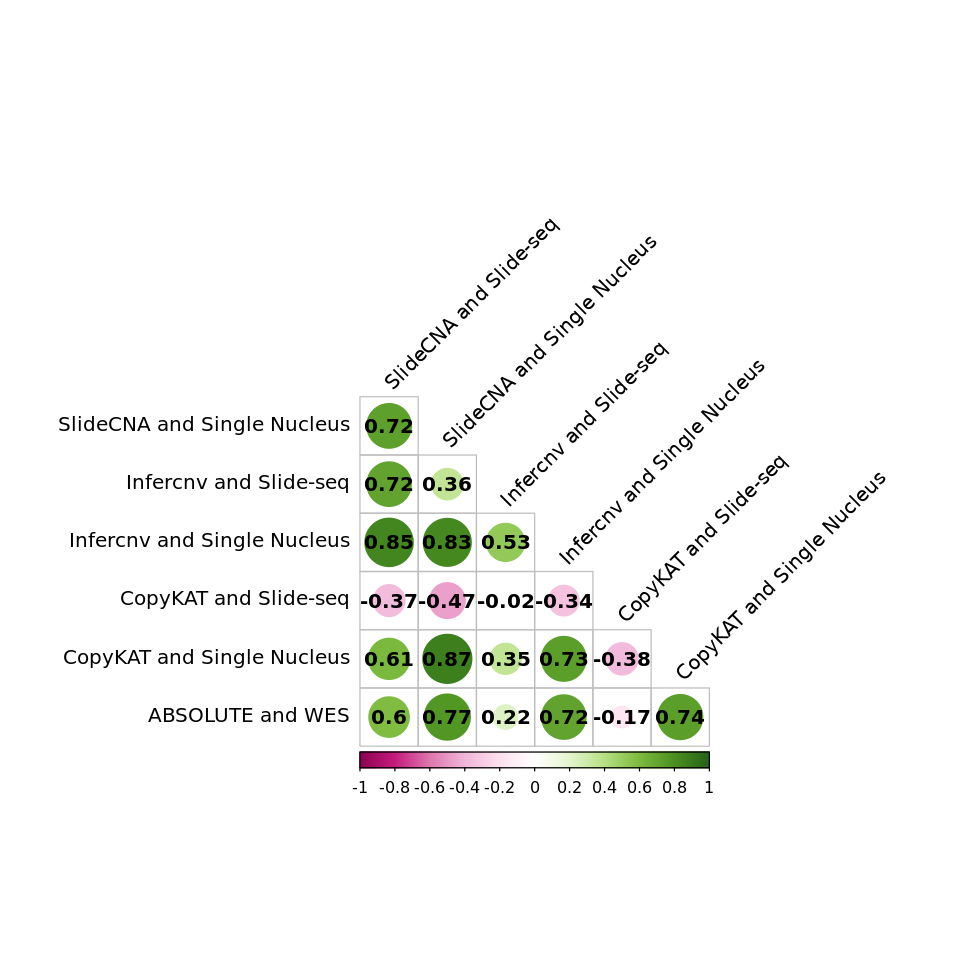

In [15]:
all_corr_plot(all_cna_avgs_shared, path_to_results, modality = "HTAPP-895-SMP-7359")

#### HTAPP-944-SMP-7479

In [51]:
sample <- "HTAPP-944-SMP-7479"

In [52]:
infercnv_obj_slide = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_slide'))
infercnv_slide <- infercnv_bands(infercnv_obj_slide, gene_pos_complete, "infercnv_slide") 

[1] "N genes: 1386"
[1] "N genes with karyotype band annotations: 1378"


In [53]:
infercnv_obj_sc = readRDS(glue('{path_to_data}/{sample}/preliminary.infercnv_obj_sc'))
infercnv_sc <- infercnv_bands(infercnv_obj_sc, gene_pos_complete, "infercnv_sc", malig_filt=FALSE) 

[1] "N genes: 6205"
[1] "N genes with karyotype band annotations: 6121"


In [54]:
load(glue('{path_to_data}/{sample}/cnv_data2_slide.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_slide.Robj'))
slidecna_slide <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_slide")

[1] "N genes: 10756"
[1] "N genes with karyotype band annotations: 10561"


In [55]:
load(glue('{path_to_data}/{sample}/cnv_data2_sc.Robj'))
load(glue('{path_to_data}/{sample}/dat_bin_scaled_sc.Robj'))
slidecna_sc <- slidecna_bands(cnv_data$malig_wide, dat_bin, gene_pos_complete, "slidecna_sc")

[1] "N genes: 14307"
[1] "N genes with karyotype band annotations: 13866"


In [56]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_slide.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_slide.Robj"))
copykat_slide <- copykat_bands(ck_results, md, sample, "copykat_slide")

In [57]:
ck_results <- read.table(glue('{path_to_data}/{sample}/out_copykat_CNA_raw_results_gene_by_cell_sc.txt'), header=TRUE)
load(glue("{path_to_data}/{sample}/md_sc.Robj"))
copykat_sc <- copykat_bands(ck_results, md, sample, "copykat_sc")

In [58]:
analysis_list <- list(infercnv_slide, infercnv_sc, 
                      slidecna_slide, slidecna_sc,
                     copykat_slide, copykat_sc)

# merge all average cna score dataframes for each analysis type in list
# include all chromosome arms, even those with NAs in some analyses
all_cna_avgs <- Reduce(function(x, y) merge(x, y, by="arm", all=TRUE), analysis_list)
all_cna_avgs <- all_cna_avgs[(str_order(all_cna_avgs$arm, numeric = TRUE)),]
head(all_cna_avgs)
                       
# merge all average cna score dataframes for each analysis type in list
# only include chromosome arms shared across all analyses; there should be no NAs
all_cna_avgs_shared <- Reduce(function(x, y) merge(x, y, by="arm", all=FALSE), analysis_list)
all_cna_avgs_shared <- all_cna_avgs_shared[(str_order(all_cna_avgs_shared$arm, numeric = TRUE)),]

,arm,infercnv_slide,infercnv_sc,slidecna_slide,slidecna_sc,copykat_slide,copykat_sc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,1p,1.0022422,1.0031350,1.0129304,1.0240273,1.0094239,1.0053370
19,1q,1.0086297,1.0162307,1.0851049,1.0495602,1.0006236,1.0088092
24,2p,0.9985117,0.9968416,0.9654360,0.9630383,1.0138879,0.9933326
25,2q,1.0006182,1.0019315,0.9860616,0.9866195,0.9945143,0.9994416
26,3p,0.9871031,0.9955197,0.9505262,1.0268032,1.0071754,1.0221955
27,3q,0.9902263,0.9940919,0.9687637,1.0351825,0.9970499,1.0183749


In [59]:
### Make heat map of average CNAs across analyses

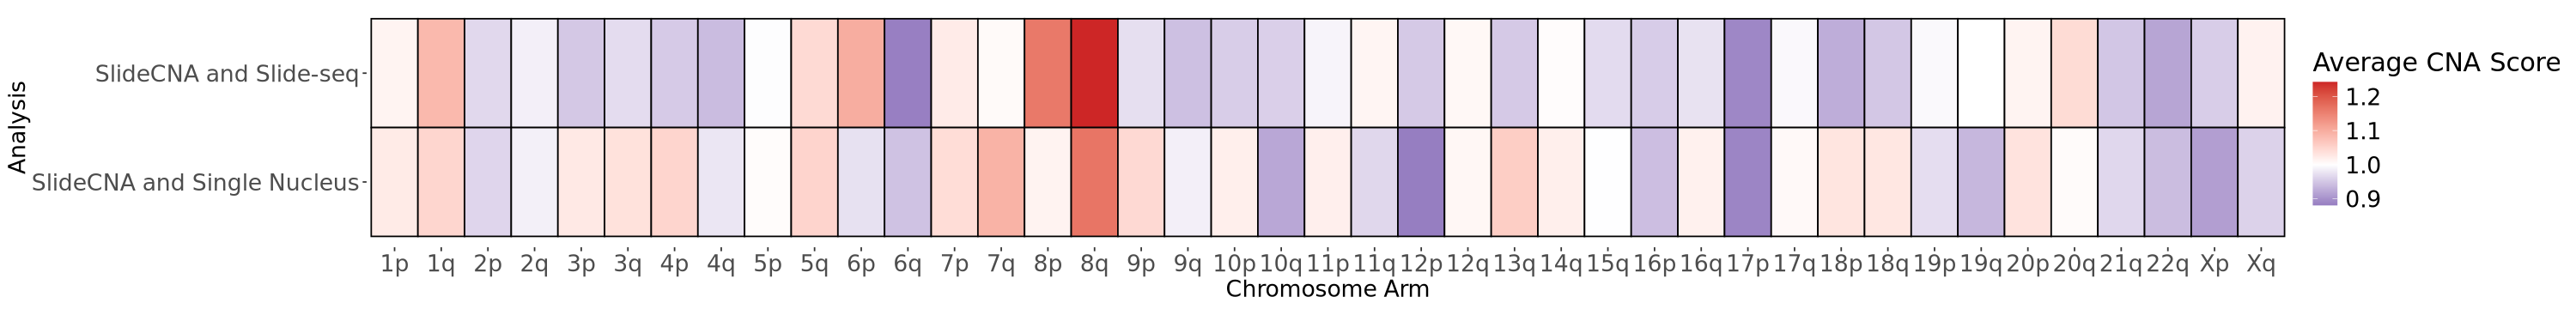

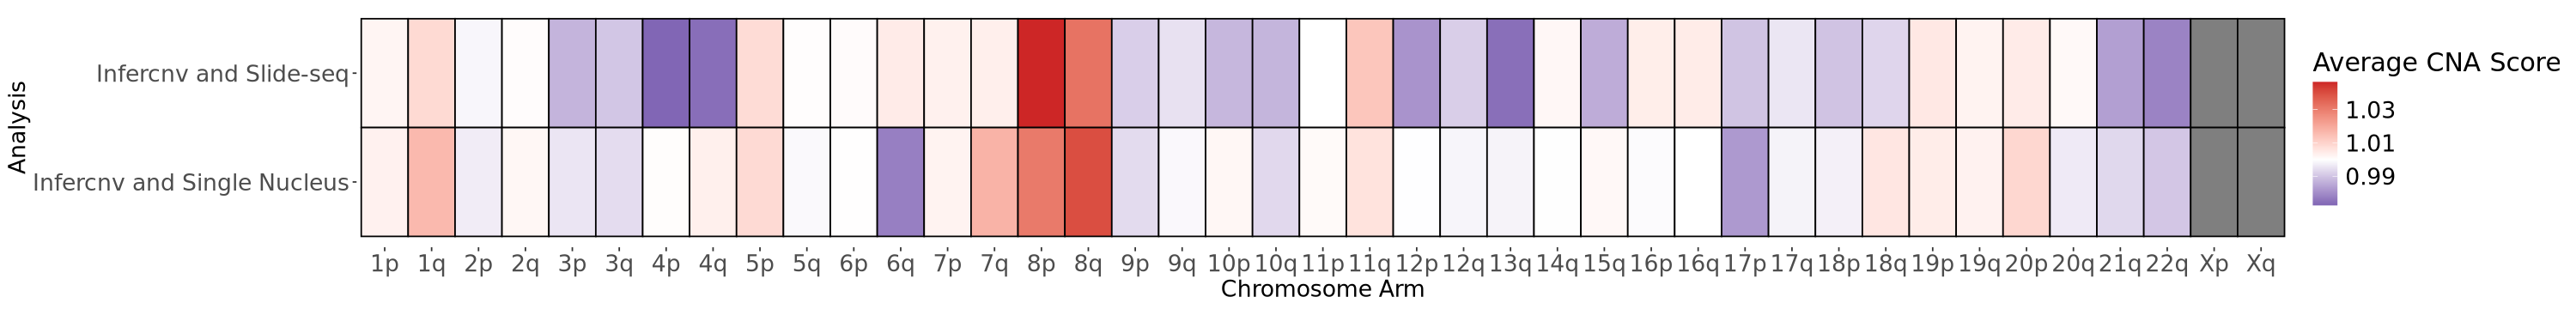

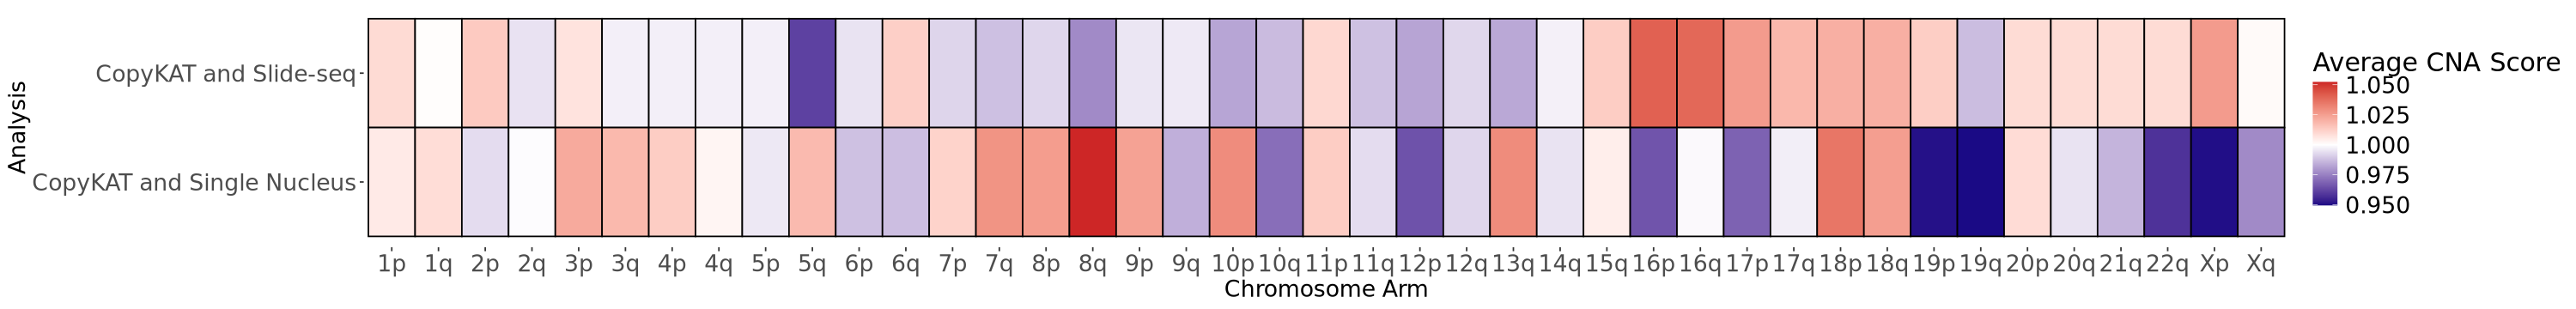

In [61]:
avg_cna_heatmap (all_cna_avgs, 'slidecna', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'infercnv', path_to_results)
avg_cna_heatmap (all_cna_avgs, 'copykat', path_to_results)

In [43]:
### Get pairwise spearman correlation for all analyses

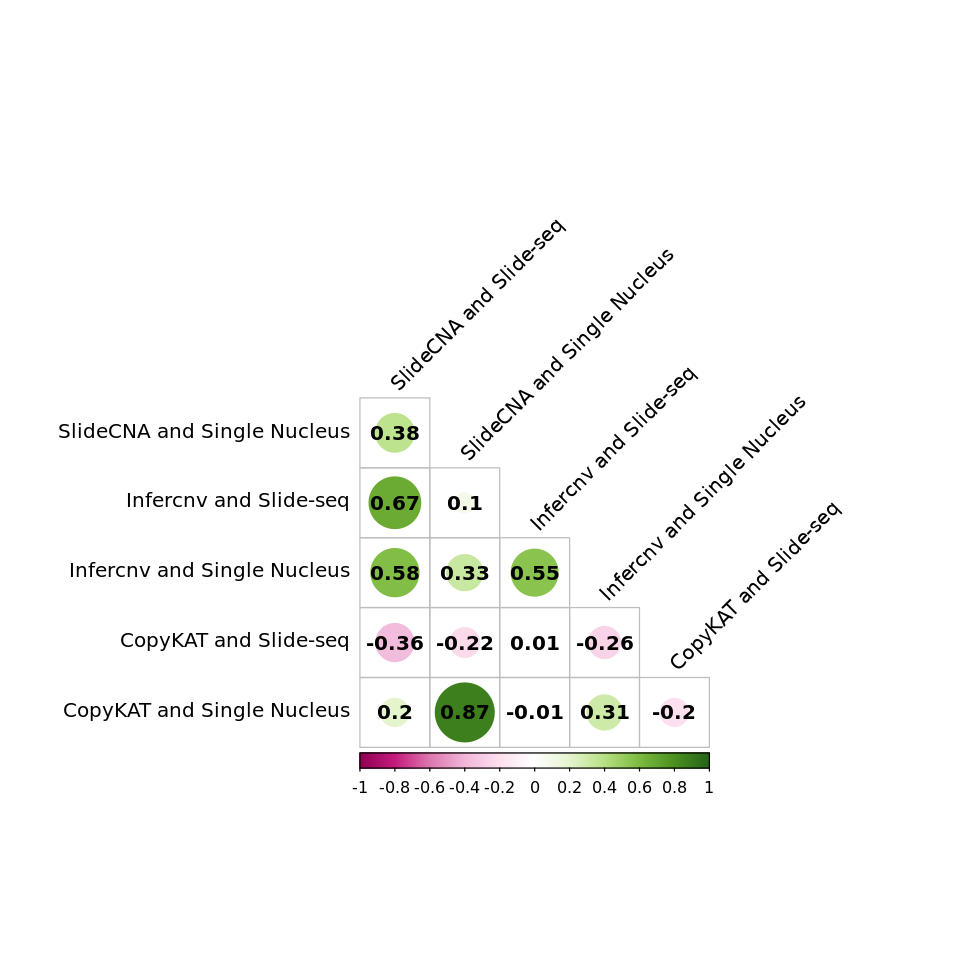

In [103]:
all_corr_plot(all_cna_avgs_shared, path_to_results)